In [ ]:
!pip install pywavelets
!pip install stockstats

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader.data as web
import plotly.express as px
import plotly.graph_objects as go
import pywt
import tensorflow as tf
import warnings

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from pandas.tseries.offsets import CustomBusinessDay, DateOffset, WeekOfMonth
from pandas.tseries.holiday import sunday_to_monday, AbstractHolidayCalendar, Holiday, USMemorialDay, USLaborDay, USColumbusDay, USThanksgivingDay
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight
import datetime as dt
from tqdm import tqdm

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})

# I. Study of the data

## 1. Data processing

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Load dataset from google drive
id = '1ATmaZrLwm1_hE1I1p7s2S1rjpLXv1ozx'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset.xlsx')

df_BcBalance = pd.read_excel("dataset.xlsx", sheet_name = 'Bilan BC')
df_BcBalance.set_index('Date', inplace = True, drop = True)
df_BcBalance = df_BcBalance.resample('D').fillna(method = 'ffill')

df_daily_data = pd.read_excel("dataset.xlsx", sheet_name = 'Données journalières')
df_daily_data.set_index('Date', inplace = True, drop = True)
del df_daily_data['CRB - Bétail']

df_EconomicalSurprise = pd.read_excel("dataset.xlsx", sheet_name = 'Surprise économique')
df_EconomicalSurprise.set_index('Date', inplace = True, drop = True)
df_EconomicalSurprise = df_EconomicalSurprise.resample('D').fillna(method = 'ffill')

df_FedBalance = pd.read_excel("dataset.xlsx", sheet_name = 'Bilan FED')
df_FedBalance.set_index('Date', inplace = True, drop = True)
df_FedBalance = df_FedBalance.resample('D').fillna(method = 'ffill')

df_gold = pd.read_excel("dataset.xlsx", sheet_name = 'Or')
df_gold.set_index('Date', inplace = True, drop = True)
df_gold = df_gold.resample('D').fillna(method = 'ffill')

df_InflationUnemployment = pd.read_excel("dataset.xlsx", sheet_name = 'Chômage & Inflation')
df_InflationUnemployment.set_index('Date', inplace = True, drop = True)
df_InflationUnemployment = df_InflationUnemployment.resample('D').fillna(method = 'ffill')

df_oil = pd.read_excel("dataset.xlsx", sheet_name = 'Pétrole')
df_oil.set_index('Date', inplace = True, drop = True)
df_oil = df_oil.resample('D').fillna(method = 'ffill')

df_ProductionCapacity = pd.read_excel("dataset.xlsx", sheet_name = 'Capacité de production')
df_ProductionCapacity.set_index('Date', inplace = True, drop = True)
df_ProductionCapacity = df_ProductionCapacity.resample('D').fillna(method = 'ffill')

df_daily_data = df_daily_data.join(df_BcBalance).join(df_EconomicalSurprise).join(df_gold).join(df_InflationUnemployment).join(df_ProductionCapacity)
df_daily_data = df_daily_data[(df_daily_data.index >= '2000-12-31') & (df_daily_data.index <= '2019-12-31')]

# Display the dataframe
df_daily_data

,SPX Index,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,MACD,BSPGCPUS Index,Surprise économique,Or,Chômage US,Confiance des consommateurs US,Inflation US,CPTICHNG Index
Date,,,,,,,,,,,,,,,,,,
2000-12-31,0.00,26.85,3.0,5.1120,6.50,223.99,214.03,255.81,184.74,245.74,0.000000,5.7,-0.218,272.0,3.9,128.55,3.4,79.9609
2001-01-01,0.00,26.85,3.0,5.1140,6.50,223.99,214.03,255.81,184.74,245.74,0.000000,5.7,-0.218,272.0,3.9,128.55,3.4,79.9609
2001-01-02,-2.80,29.99,3.0,4.9150,6.50,222.54,211.24,253.76,183.96,244.15,-15.078643,5.7,-0.218,270.0,3.9,128.55,3.4,79.9609
2001-01-03,5.01,26.60,3.0,5.1580,6.00,222.53,210.76,253.53,184.17,244.15,-11.375763,5.7,-0.218,269.3,3.9,128.55,3.4,79.9609
2001-01-04,-1.06,26.97,3.0,5.0390,6.00,222.80,210.62,253.95,184.29,243.49,-9.479367,5.7,-0.218,268.4,3.9,128.55,3.4,79.9609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.00,13.43,2.1,1.8752,1.75,401.00,758.15,451.65,337.44,280.76,36.932393,18.8,0.138,1513.8,3.5,126.80,2.1,77.5723
2019-12-28,0.00,13.43,2.1,1.8752,1.75,401.00,758.15,451.65,337.44,280.76,0.000000,18.8,0.138,1513.8,3.5,126.80,2.1,77.5723
2019-12-29,0.00,13.43,2.1,1.8752,1.75,401.00,758.15,451.65,337.44,280.76,0.000000,18.8,0.138,1513.8,3.5,126.80,2.1,77.5723


In [ ]:
class BankCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1, observance=sunday_to_monday),
        Holiday("Martin Luther King Jr.'s Birthday", month=1, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        Holiday("Washington's Birthday", month=2, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        USMemorialDay,
        Holiday("Independence Day", month=7, day=4, observance=sunday_to_monday),
        USLaborDay,
        USColumbusDay,
        Holiday("Veteran's Day", month=11, day=11, observance=sunday_to_monday),
        USThanksgivingDay,
        Holiday("Christmas Day", month=12, day=25, observance=sunday_to_monday),
    ]

In [ ]:
# Keep only bank business days
Bank_business_days = CustomBusinessDay(calendar = BankCalendar())
business_days = pd.date_range('2000-12-31', end = '2019-12-31', freq = Bank_business_days)
df_business_days = pd.DataFrame(business_days, columns = ['Date'])
df_business_days.set_index('Date', inplace = True, drop = True)
df_daily_data = df_daily_data.join(df_business_days, how = 'right')

# Display the dataframe
df_daily_data

,SPX Index,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,MACD,BSPGCPUS Index,Surprise économique,Or,Chômage US,Confiance des consommateurs US,Inflation US,CPTICHNG Index
Date,,,,,,,,,,,,,,,,,,
2001-01-02,-2.80,29.99,3.0,4.9150,6.50,222.54,211.24,253.76,183.96,244.15,-15.078643,5.7,-0.218,270.0,3.9,128.55,3.4,79.9609
2001-01-03,5.01,26.60,3.0,5.1580,6.00,222.53,210.76,253.53,184.17,244.15,-11.375763,5.7,-0.218,269.3,3.9,128.55,3.4,79.9609
2001-01-04,-1.06,26.97,3.0,5.0390,6.00,222.80,210.62,253.95,184.29,243.49,-9.479367,5.7,-0.218,268.4,3.9,128.55,3.4,79.9609
2001-01-05,-2.62,28.67,3.0,4.9310,6.00,223.70,210.83,254.36,185.68,243.43,-10.676785,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-08,-0.19,29.84,3.0,4.9560,6.00,224.48,211.59,255.17,186.40,244.80,-11.691893,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.02,12.67,2.1,1.8996,1.75,398.81,757.07,451.23,333.39,280.42,34.643269,18.8,0.138,1499.1,3.5,126.80,2.1,77.5723
2019-12-26,0.51,12.65,2.1,1.8944,1.75,399.49,758.45,451.60,334.39,280.52,36.152876,18.8,0.138,1509.3,3.5,126.80,2.1,77.5723
2019-12-27,0.00,13.43,2.1,1.8752,1.75,401.00,758.15,451.65,337.44,280.76,36.932393,18.8,0.138,1513.8,3.5,126.80,2.1,77.5723


In [ ]:
start = dt.datetime(2000, 12, 31)
end = dt.datetime(2019, 12, 31)

df_SPX_stocks = web.DataReader(['^GSPC'], 'yahoo', start, end)
df_SPX_stocks.columns = ['Ajd Close', 'Close', 'High', 'Low' ,'Open', 'Volume']
df_SPX_stocks

,Ajd Close,Close,High,Low,Open,Volume
Date,,,,,,
2001-01-02,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000
2001-01-03,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000
2001-01-04,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000
2001-01-05,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000
2001-01-08,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000
...,...,...,...,...,...,...
2019-12-24,3223.379883,3223.379883,3226.429932,3220.510010,3225.449951,1296540000
2019-12-26,3239.909912,3239.909912,3240.080078,3227.199951,3227.199951,2160680000
2019-12-27,3240.020020,3240.020020,3247.929932,3234.370117,3247.229980,2428670000


In [ ]:
from stockstats import StockDataFrame as Sdf
df_stocks = Sdf.retype(df_SPX_stocks)
df_SPX_stocks['RSI'] = df_stocks['rsi_14']
del df_SPX_stocks['close_-1_s']
del df_SPX_stocks['close_-1_d']
del df_SPX_stocks['rs_14']
del df_SPX_stocks['rsi_14']
del df_SPX_stocks['closepm']
del df_SPX_stocks['closenm']
del df_SPX_stocks['closepm_14_smma']
del df_SPX_stocks['closenm_14_smma']
df_SPX_stocks['CCI']= df_stocks['cci']
df_SPX_stocks['STCK%']= df_stocks['kdjk']
df_SPX_stocks['ADO'] = (df_SPX_stocks['high'] - df_SPX_stocks['close'])/ (df_SPX_stocks['high'] - df_SPX_stocks['low'])
df_SPX_stocks.columns = ['Ajd Closing Price', 'Closing Price', 'High', 'Low' ,'Openening Price', 'Volume', 'RSI', 'CCI', 'STCK%', 'ADO']
df_SPX_stocks

,Ajd Closing Price,Closing Price,High,Low,Openening Price,Volume,RSI,CCI,STCK%,ADO
Date,,,,,,,,,,
2001-01-02,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000,NaN,NaN,38.774568,0.836763
2001-01-03,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000,100.000000,66.666667,59.091918,0.002734
2001-01-04,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000,80.762337,78.716507,65.278406,0.800950
2001-01-05,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000,53.492969,-29.735146,53.979125,0.914615
2001-01-08,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000,52.143676,-86.857456,45.348682,0.112874
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,3223.379883,3223.379883,3226.429932,3220.510010,3225.449951,1296540000,75.832040,101.064316,94.748484,0.515218
2019-12-26,3239.909912,3239.909912,3240.080078,3227.199951,3227.199951,2160680000,78.415059,113.069057,96.431116,0.013212
2019-12-27,3240.020020,3240.020020,3247.929932,3234.370117,3247.229980,2428670000,78.431595,111.731236,93.520222,0.583335


In [ ]:
df_daily_data = df_daily_data.merge(df_SPX_stocks, how = 'inner', on = 'Date')
df_daily_data

,SPX Index,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,MACD,BSPGCPUS Index,Surprise économique,Or,Chômage US,Confiance des consommateurs US,Inflation US,CPTICHNG Index,Ajd Closing Price,Closing Price,High,Low,Openening Price,Volume,RSI,CCI,STCK%,ADO
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-02,-2.80,29.99,3.0,4.9150,6.50,222.54,211.24,253.76,183.96,244.15,-15.078643,5.7,-0.218,270.0,3.9,128.55,3.4,79.9609,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000,NaN,NaN,38.774568,0.836763
2001-01-03,5.01,26.60,3.0,5.1580,6.00,222.53,210.76,253.53,184.17,244.15,-11.375763,5.7,-0.218,269.3,3.9,128.55,3.4,79.9609,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000,100.000000,66.666667,59.091918,0.002734
2001-01-04,-1.06,26.97,3.0,5.0390,6.00,222.80,210.62,253.95,184.29,243.49,-9.479367,5.7,-0.218,268.4,3.9,128.55,3.4,79.9609,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000,80.762337,78.716507,65.278406,0.800950
2001-01-05,-2.62,28.67,3.0,4.9310,6.00,223.70,210.83,254.36,185.68,243.43,-10.676785,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000,53.492969,-29.735146,53.979125,0.914615
2001-01-08,-0.19,29.84,3.0,4.9560,6.00,224.48,211.59,255.17,186.40,244.80,-11.691893,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000,52.143676,-86.857456,45.348682,0.112874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.02,12.67,2.1,1.8996,1.75,398.81,757.07,451.23,333.39,280.42,34.643269,18.8,0.138,1499.1,3.5,126.80,2.1,77.5723,3223.379883,3223.379883,3226.429932,3220.510010,3225.449951,1296540000,75.832040,101.064316,94.748484,0.515218
2019-12-26,0.51,12.65,2.1,1.8944,1.75,399.49,758.45,451.60,334.39,280.52,36.152876,18.8,0.138,1509.3,3.5,126.80,2.1,77.5723,3239.909912,3239.909912,3240.080078,3227.199951,3227.199951,2160680000,78.415059,113.069057,96.431116,0.013212
2019-12-27,0.00,13.43,2.1,1.8752,1.75,401.00,758.15,451.65,337.44,280.76,36.932393,18.8,0.138,1513.8,3.5,126.80,2.1,77.5723,3240.020020,3240.020020,3247.929932,3234.370117,3247.229980,2428670000,78.431595,111.731236,93.520222,0.583335


## 2. Data analysis

In [ ]:
area_chart = px.area(df_SPX_stocks, x = df_SPX_stocks.index, y = df_SPX_stocks['Closing Price'], title = 'S&P500 Closing Price (2001-2019)')

area_chart.update_xaxes(title_text = 'Date')
area_chart.update_yaxes(title_text = 'S&P500 Closing Price', tickprefix = '$')
area_chart.update_layout(showlegend = True)

area_chart.show()

In [ ]:
candlestick = go.Figure(data = [go.Candlestick(x = df_SPX_stocks.index, 
                                               open = df_SPX_stocks['Openening Price'], 
                                               high = df_SPX_stocks['High'], 
                                               low = df_SPX_stocks['Low'], 
                                               close = df_SPX_stocks['Closing Price'])])

candlestick.update_layout(xaxis_rangeslider_visible = False, title = 'S&P500 SHARE PRICE (2001-2019)')
candlestick.update_xaxes(title_text = 'Date')
candlestick.update_yaxes(title_text = 'S&P500 Close Price', tickprefix = '$')

candlestick.show()

In [ ]:
c_candlestick  = go.Figure(data = [go.Candlestick(x = df_SPX_stocks.index, 
                                               open = df_SPX_stocks['Openening Price'], 
                                               high = df_SPX_stocks['High'], 
                                               low = df_SPX_stocks['Low'], 
                                               close = df_SPX_stocks['Closing Price'])])


c_candlestick.update_xaxes(
    title_text = 'Date',
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = '1M', step = 'month', stepmode = 'backward'),
            dict(count = 6, label = '6M', step = 'month', stepmode = 'backward'),
            dict(count = 1, label = 'YTD', step = 'year', stepmode = 'todate'),
            dict(count = 1, label = '1Y', step = 'year', stepmode = 'backward'),
            dict(step = 'all')])))

c_candlestick.update_layout(
    title = {
        'text': 'S&P500 SHARE PRICE (2001-2019)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

c_candlestick.update_yaxes(title_text = 'S&P500 Close Price', tickprefix = '$')
c_candlestick.show()

# II. Trends modeling

## 1.1. Trends models

In [ ]:
def trends_model_difference(df, trends_window):
  n = len(df)
  trends = []
  for i in range(trends_window - 1, n):
    if df[i] - df[i - trends_window + 1] > 0:
      trends.append(1)
    else :
      trends.append(0)
  if len(trends) == 1:
    return trends[0]
  else :
    return trends

In [ ]:
def trends_model_average(df, trends_window, last_average):
  trends = []
  n = len(df)
  for i in range(trends_window - 1, n):
    difference = df[i - trends_window + 2:i + 1].mean() - last_average
    if difference > 0:
      trends.append(1)
    else:
      trends.append(0)
    last_average = df[i - trends_window + 2:i + 1].mean()       
  if len(trends) == 1:
    return trends[0]
  else :
    return trends

In [ ]:
def mma(df, trends_window):
  return df.copy().rolling(trends_window).mean()

def trends_model_mma(df, trends_window):
  mma_computed = mma(df, trends_window)
  return np.array((df > mma_computed)*1 + (df <= mma_computed)*(0))

In [ ]:
def mme(df, trends_window):
  return df.transform(lambda x: x.ewm(span = trends_window, adjust = False).mean())

def trends_model_mme(df, trends_window):
  mme_computed = mme(df, trends_window)
  return np.array((df > mme_computed)*1 + (df <= mme_computed)*(0))

In [ ]:
def macd(df, trends_window_1, trends_window_2):
  if trends_window_1 < trends_window_2 :
    return mme(df, trends_window_2) - mme(df, trends_window_1)
  else :
    return mme(df, trends_window_1) - mme(df, trends_window_2)

def trends_model_macd(df, trends_window_1, trends_window_2, trends_window_3):
  difference = macd(df, trends_window_1, trends_window_2) - mme(df, trends_window_3)
  return (df > difference)*1 + (df <= difference)*(0)

In [ ]:
def trends_model_next(df, trends_window):
  trends = []
  n = len(df)
  for i in range(n - 1):
    if df[i + trends_window - 1] > df[i]:
      trends.append(1)
    else:
      trends.append(0)
  return trends

In [ ]:
def trends_model_rsi(df, trends_window):
  trends = []
  n = len(df)
  for i in range(n - 1):
    if df[i + trends_window - 1] > 70:
      trends.append(0)
    elif df[i + trends_window - 1] < 30:
      trends.append(1)
    else:
      if df[i + trends_window - 1] > df[i]:
        trends.append(1)
      else:
        trends.append(0)
  return trends

In [ ]:
def trends_model_cci(df, trends_window):
  trends = []
  n = len(df)
  for i in range(n - 1):
    if df[i + trends_window - 1] > 200:
      trends.append(0)
    elif df[i + trends_window - 1] < -200:
      trends.append(1)
    else:
      if df[i + trends_window - 1] > df[i]:
        trends.append(1)
      else:
        trends.append(0)
  return trends

## 1.2. Trends analysis

### Nouvelle section

In [ ]:
def trends_accuracy(predicted_trends, expected_trends):
  accuracy = (predicted_trends == expected_trends).sum()/len(predicted_trends)
  return accuracy

In [ ]:
def trends_accuracies(df):
  df_trends_accuracies = pd.DataFrame(columns = df.columns, index = df.columns)
  for column in df_trends_accuracies.columns :
    for row in df_trends_accuracies.index :
      df_trends_accuracies[column][row] = trends_accuracy(df[column], df[row])
  return df_trends_accuracies

In [ ]:
def classes_proportion(df_trends):
  df_proportion = pd.DataFrame(columns = [model for model in df_trends.columns], index = ['Class 0', 'Class 1'])
  n = len(df_trends)
  for model in df_trends.columns :
    for label in df_trends[model].unique():
      df_proportion[model]['Class ' + str(label)] = (len(df_trends[model][df_trends[model] == label])/n) * 100
  return(df_proportion)

In [ ]:
np.random.seed(7)

In [ ]:
trends_window_1 = 2
last_average_1 = df_daily_data['Closing Price'][: trends_window_1 - 1].mean()
df_expected_trends = pd.DataFrame(index = df_daily_data.index[: - trends_window_1 + 1])
df_expected_trends['Average'] = trends_model_average(df_daily_data['Closing Price'].copy(), trends_window_1, last_average_1)
df_expected_trends['Difference'] = trends_model_difference(df_daily_data['Closing Price'].copy(), trends_window_1)
df_expected_trends['MMA'] = trends_model_mma(df_daily_data['Closing Price'], trends_window_1)[trends_window_1 - 1:]
df_expected_trends['MME'] = trends_model_mme(df_daily_data['Closing Price'], trends_window_1)[trends_window_1 - 1:]
df_expected_trends['ADO'] = trends_model_next(df_daily_data['ADO'], trends_window_1)
df_expected_trends['STCK%'] = trends_model_next(df_daily_data['STCK%'], trends_window_1)
df_expected_trends['MACD'] = trends_model_next(df_daily_data['MACD'], trends_window_1)
df_expected_trends['RSI'] = trends_model_rsi(df_daily_data['RSI'], trends_window_1)
df_expected_trends['CCI'] = trends_model_cci(df_daily_data['CCI'], trends_window_1)
df_expected_trends

,Average,Difference,MMA,MME,ADO,STCK%,MACD,RSI,CCI
Date,,,,,,,,,
2001-01-02,1,1,1,1,0,1,1,0,0
2001-01-03,0,0,0,1,1,1,1,0,1
2001-01-04,0,0,0,0,1,0,0,0,0
2001-01-05,0,0,0,0,0,0,0,0,0
2001-01-08,1,1,1,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...
2019-12-23,0,0,0,1,0,1,1,0,0
2019-12-24,1,1,1,1,0,1,1,0,1
2019-12-26,1,1,1,1,1,0,1,0,0


In [ ]:
df_trends_accuracies = trends_accuracies(df_expected_trends)
df_trends_accuracies

,Average,Difference,MMA,MME,ADO,STCK%,MACD,RSI,CCI
Average,1,1,1,0.873724,0.284439,0.785077,0.704294,0.931973,0.759991
Difference,1,1,1,0.873724,0.284439,0.785077,0.704294,0.931973,0.759991
MMA,1,1,1,0.873724,0.284439,0.785077,0.704294,0.931973,0.759991
MME,0.873724,0.873724,0.873724,1,0.380952,0.859056,0.796556,0.806548,0.749362
ADO,0.284439,0.284439,0.284439,0.380952,1,0.412628,0.46875,0.30017,0.432185
STCK%,0.785077,0.785077,0.785077,0.859056,0.412628,1,0.79932,0.738733,0.733844
MACD,0.704294,0.704294,0.704294,0.796556,0.46875,0.79932,1,0.647321,0.62585
RSI,0.931973,0.931973,0.931973,0.806548,0.30017,0.738733,0.647321,1,0.751913
CCI,0.759991,0.759991,0.759991,0.749362,0.432185,0.733844,0.62585,0.751913,1


In [ ]:
classes_proportion(df_expected_trends)

,Average,Difference,MMA,MME,ADO,STCK%,MACD,RSI,CCI
Class 0,46.0672,46.0672,46.0672,43.176,49.5536,47.1088,48.682,49.1284,50.2551
Class 1,53.9328,53.9328,53.9328,56.824,50.4464,52.8912,51.318,50.8716,49.7449


# III. Deep learning for financial forecasting

## 1. Long Short-Term Memory

### a. Some useful functions

In [ ]:
def create_data(X, Y, time_step):
  X_lagged, Y_lagged = [], []
  for i in range(len(X) - time_step):
    X_lagged.append(X[i: i + time_step, :])
    Y_lagged.append(Y[i + time_step])
  return np.array(X_lagged), np.array(Y_lagged)

In [ ]:
def plot_confusion_matrix(df_confusion_matrix):
  fig = sns.heatmap(df_confusion_matrix, annot = True, fmt = 'g' )
  fig.set_xlabel('Actual trends')
  fig.set_ylabel('Predicted trends')
  fig.set_title('Confusion Matrix ')
  fig.xaxis.set_ticklabels(['Positives', 'Negatives'])
  fig.yaxis.set_ticklabels(['Positives', 'Negatives'])

### b. The study with S&P500 closing price

In [ ]:
df_daily_data_sample = df_daily_data[['SPX Index', 'Surprise économique', 'Vix Index', 'Confiance des consommateurs US', 'Inflation US', 'MACD', 'FDTR Index']][trends_window_1 - 1:].copy()
df_daily_data_sample

,SPX Index,Surprise économique,Vix Index,Confiance des consommateurs US,Inflation US,MACD,FDTR Index
Date,,,,,,,
2001-01-03,5.01,-0.218,26.60,128.55,3.4,-11.375763,6.00
2001-01-04,-1.06,-0.218,26.97,128.55,3.4,-9.479367,6.00
2001-01-05,-2.62,-0.218,28.67,128.55,3.4,-10.676785,6.00
2001-01-08,-0.19,-0.218,29.84,128.55,3.4,-11.691893,6.00
2001-01-09,0.38,-0.218,27.99,128.55,3.4,-11.959890,6.00
...,...,...,...,...,...,...,...
2019-12-24,-0.02,0.138,12.67,126.80,2.1,34.643269,1.75
2019-12-26,0.51,0.138,12.65,126.80,2.1,36.152876,1.75
2019-12-27,0.00,0.138,13.43,126.80,2.1,36.932393,1.75


In [ ]:
sc = MinMaxScaler(feature_range = (0,1))
n_train = int(0.8*len(df_daily_data_sample))
time_step_1 = 60
trends_model = 'CCI'
X_train_1 , Y_train_1 = df_daily_data_sample[:n_train].values, df_expected_trends[trends_model][:n_train].values
X_train_lagged_1 , Y_train_lagged_1 = create_data(X_train_1, Y_train_1, time_step_1)

In [ ]:
df_Y_train = pd.DataFrame(data = Y_train_lagged_1, columns = [trends_model])

In [ ]:
X_test_1, Y_test_1 = df_daily_data_sample[n_train:].values, df_expected_trends[trends_model][n_train:].values
X_test_lagged_1, Y_test_lagged_1 = create_data(X_test_1, Y_test_1, time_step_1)

In [ ]:
df_Y_test = pd.DataFrame(data = Y_test_lagged_1, columns = [trends_model])

In [ ]:
model = Sequential()
model.add(LSTM(units = 250, input_shape = (X_train_lagged_1.shape[1], X_train_lagged_1.shape[2]))) 
model.add(Dropout(0.4))
model.add(Dense(units = 150))
model.add(Dropout(0.2))
model.add(Dense(units = 200, activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(units = 2, activation = 'softmax'))

epochs = 20
batch_size = 16

class_weight = None
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min')
mcp_save = ModelCheckpoint(filepath = 'LSTM.hdf5', save_best_only = True, monitor = 'val_loss', mode = 'max')
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) 

history = model.fit(X_train_lagged_1, Y_train_lagged_1, epochs = epochs, batch_size = batch_size, callbacks = [mcp_save], class_weight = class_weight, validation_data = (X_test_lagged_1, Y_test_lagged_1))

Epoch 1/20
232/232 [==============================] - 4s 9ms/step - loss: 0.8620 - accuracy: 0.5111 - val_loss: 0.6689 - val_accuracy: 0.6107
Epoch 2/20
232/232 [==============================] - 2s 7ms/step - loss: 0.7223 - accuracy: 0.5431 - val_loss: 0.6698 - val_accuracy: 0.5868
Epoch 3/20
232/232 [==============================] - 2s 7ms/step - loss: 0.7080 - accuracy: 0.5447 - val_loss: 0.6747 - val_accuracy: 0.6118
Epoch 4/20
232/232 [==============================] - 2s 7ms/step - loss: 0.6751 - accuracy: 0.5870 - val_loss: 0.6789 - val_accuracy: 0.6118
Epoch 5/20
232/232 [==============================] - 2s 7ms/step - loss: 0.6651 - accuracy: 0.6035 - val_loss: 0.6686 - val_accuracy: 0.6095
Epoch 6/20
232/232 [==============================] - 2s 7ms/step - loss: 0.6604 - accuracy: 0.6141 - val_loss: 0.6612 - val_accuracy: 0.6118
Epoch 7/20
232/232 [==============================] - 2s 7ms/step - loss: 0.6483 - accuracy: 0.6384 - val_loss: 0.6597 - val_accuracy: 0.6084
Epoch 

In [ ]:
df_LSTM_accuracies = pd.DataFrame(columns = ['Train', 'Validation'], index = ['Average Accuracy'])
df_LSTM_accuracies['Train'] = np.mean(history.history['accuracy'])
df_LSTM_accuracies['Validation'] = np.mean(history.history['val_accuracy'])
df_LSTM_accuracies

,Train,Validation
Average Accuracy,0.623076,0.619296


[Text(0, 0.5, 'Loss'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, 'Loss as a function of the number of epochs')]

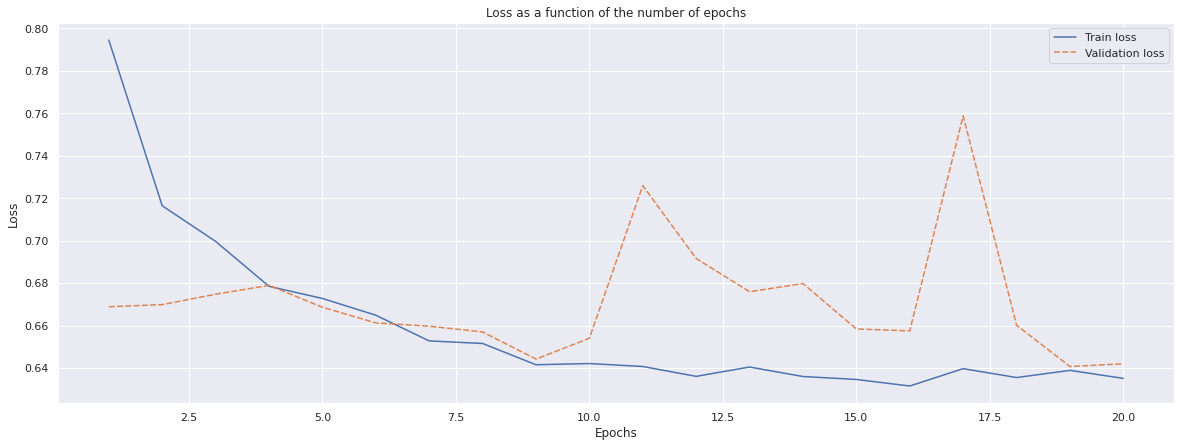

In [ ]:
df_losses = pd.DataFrame(index = [i + 1 for i in range(epochs)])
df_losses['Train loss'] = history.history['loss']
df_losses['Validation loss'] = history.history['val_loss']
fig = sns.lineplot(data = df_losses)
fig.set(xlabel = 'Epochs', ylabel = 'Loss', title = 'Loss as a function of the number of epochs')

In [ ]:
actual_label, actual_label_count = np.unique(Y_test_lagged_1, return_counts = True)
data_dict = dict(zip(actual_label, actual_label_count))

print('Actual labels: ', dict(zip(actual_label, actual_label_count)))
forecast_proba = model.predict(X_test_lagged_1)
forecasted_labels = np.argmax(forecast_proba, axis = 1)
get_confusion_matrix = metrics.confusion_matrix(Y_test_lagged_1, forecasted_labels)

predicted_labels, predicted_label_counts = np.unique(forecasted_labels, return_counts = True)
print('Predicted labels: ', dict(zip(predicted_labels, predicted_label_counts)))
print(' ')
print('Confusion matrix of predicted data:')
print(pd.DataFrame(get_confusion_matrix))
print(' ')

for i in range(len(predicted_labels)):
    print('Label {0} accuracy: {1:0.1f}%'.format(i, 100 * get_confusion_matrix[i,i]/actual_label_count[i]))

Actual labels:  {0: 453, 1: 428}
Predicted labels:  {0: 552, 1: 329}
 
Confusion matrix of predicted data:
     0    1
0  340  113
1  212  216
 
Label 0 accuracy: 75.1%
Label 1 accuracy: 50.5%


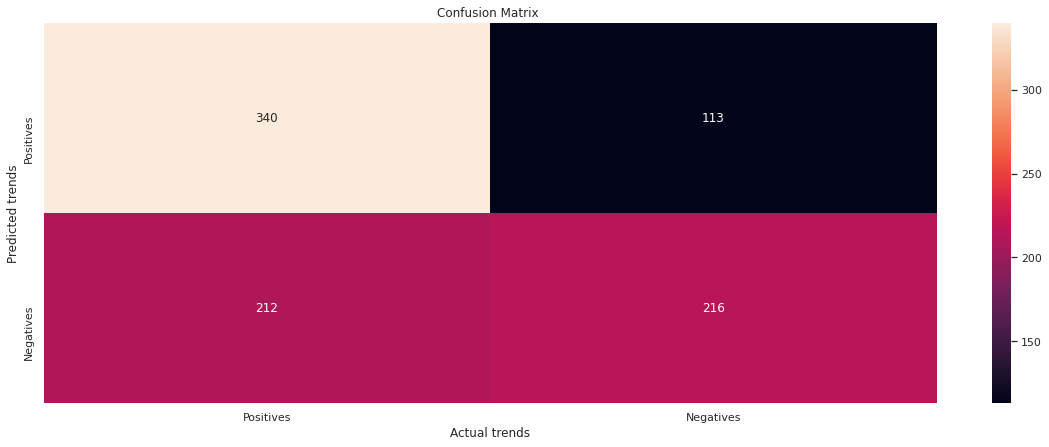

In [ ]:
plot_confusion_matrix(confusion_matrix(Y_test_lagged_1, forecasted_labels))

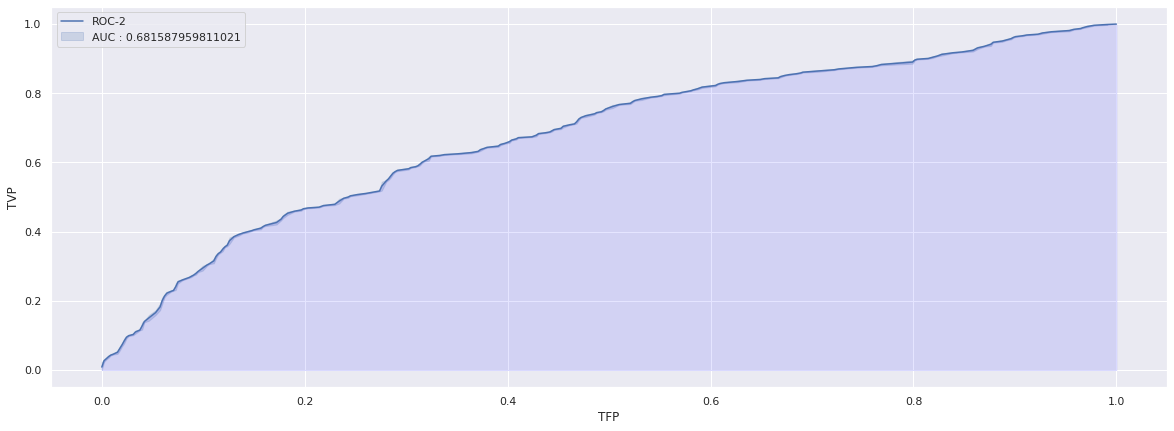

In [ ]:
df_roc_trends_window_1 = pd.DataFrame()
df_roc_trends_window_1['TFP'], df_roc_trends_window_1['TVP'], thresholds = metrics.roc_curve(Y_test_lagged_1, forecast_proba[:,1])
auc = metrics.roc_auc_score(Y_test_lagged_1, forecast_proba[:,1])
fig = sns.lineplot(x = df_roc_trends_window_1['TFP'], y = df_roc_trends_window_1['TVP'])
fig.fill_between(fig.lines[0].get_xydata()[:,0] , fig.lines[0].get_xydata()[:,1], color = "blue", alpha = 0.1)
fig.legend(labels = ['ROC-' + str(trends_window_1), 'AUC : ' + str(auc)])

In [ ]:
y = []
for i in range(len(df_daily_data['SPX Index'][n_train: - trends_window_1 + 1]) - time_step_1):
  y.append(df_daily_data['SPX Index'][n_train: - trends_window_1 + 1][i + time_step_1])
y = np.array(y)

[Text(0, 0.5, 'Price'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Trading bot performances')]

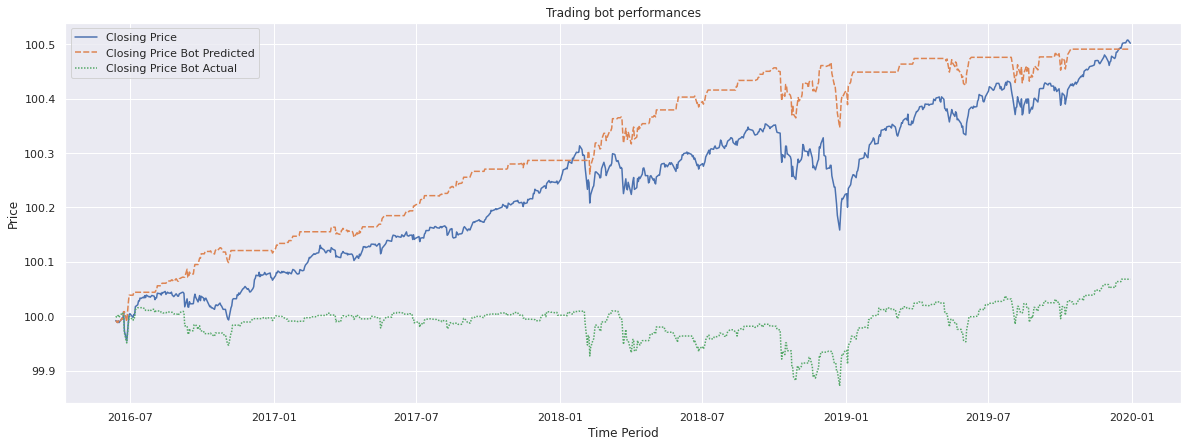

In [ ]:
base = 100
df_bot = pd.DataFrame({'SPX Index' : y/100, 'Predicted' : forecasted_labels, 'Actual': Y_test_lagged_1}, index = df_expected_trends.index[n_train + time_step_1:])
df_bot['Predictions performances'] = df_bot['SPX Index'] * df_bot['Predicted']
df_bot['Closing Price'] = base * (1 + df_bot['SPX Index'].copy()/100).cumprod()
df_bot['Closing Price Bot Predicted'] = base * (1 + df_bot['Predictions performances'].copy() / 100).cumprod()
df_bot['Actual performances'] = df_bot['SPX Index'] * df_bot['Actual']
df_bot['Closing Price Bot Actual'] = base * (1 + df_bot['Actual performances'].copy() / 100).cumprod()
fig = sns.lineplot(data = df_bot[['Closing Price', 'Closing Price Bot Predicted', 'Closing Price Bot Actual']])
fig.set(xlabel='Time Period', ylabel = 'Price', title = 'Trading bot performances')